# Pré processamento

In [101]:
# Importando as bibliotecas e construindo o dataframe
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import faiss
import random
from sklearn.impute import KNNImputer
from sentence_transformers import SentenceTransformer
from statistics import mean


In [102]:
# concatenando dois dataframes (um com fake news e outro com noticias verdadeiras)
fake_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/Fake.csv')
true_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/True.csv')
# adicionando coluna label, correspondente a veracidade da noticias (1 para verdadeiro e 0 para falsa)
fake_df['label'] = 0
true_df['label'] = 1

combined_df = pd.concat([fake_df, true_df], ignore_index=True)

combined_df.to_csv('Combined.csv', index=False)
combined_df.reset_index(drop=True,inplace=True)
combined_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia

In [103]:
# criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia
import re
# regex para substituir caracteres que não forem letras e números
regex = r'[^a-zA-Z0-9\s]'
combined_df['text'] = combined_df['text'].map(lambda x: re.sub(regex, '', x))
combined_df['num_of_words'] = combined_df['text'].map(lambda x: len(x.split()))

# Criando nova coluna com texto vetorizado 

In [ ]:
# Initialize the Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to vectorize the text
def vectorize_text(text):
    return model.encode(text)

# Apply the function to create a new column with vectorized text
combined_df['text_vector'] = combined_df['text'].map(vectorize_text)
combined_df.to_csv('vectorized_texts.csv', index=False)

# Reading from csv file 

In [104]:
# Função para converter strings de vetores em numpy arrays de forma segura
def str_to_array(vector_str):
    try:
        # Remover caracteres desnecessários e converter a string para um numpy array
        cleaned_str = vector_str.replace('\n', '').replace('[', '').replace(']', '').replace('  ', ' ')
        return np.fromstring(cleaned_str, sep=' ')
    except Exception as e:
        print(f"Error converting string to array: {e}")
        return np.nan

def convert_text_vectors_from_str_to_np_arr():
    # Certifique-se de que os vetores de texto sejam numpy arrays, não strings
    df['text_vector'] = df['text_vector'].map(str_to_array) if isinstance(df['text_vector'][0], str) else df['text_vector']

    # Verifique se todos os vetores têm o mesmo tamanho
    vector_length = len(df['text_vector'][0])
    df['text_vector'] = df['text_vector'].map(lambda x: x if len(x) == vector_length else np.nan).dropna()

In [105]:
combined_df = pd.read_csv('vectorized.csv')
df = combined_df
convert_text_vectors_from_str_to_np_arr()
combined_df.head()

,title,text,subject,date,label,num_of_words,text_vector
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,492,"[-0.08635634, 0.16764247, 0.40040964, -0.36150..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,305,"[0.00671101, 0.0081033, -0.20852128, -0.087897..."
2,Sheriff David Clarke Becomes An Internet Joke...,On Friday it was revealed that former Milwauke...,News,"December 30, 2017",0,579,"[-0.362045884, -0.123025492, -0.551379442, -0...."
3,Trump Is So Obsessed He Even Has Obama’s Name...,On Christmas day Donald Trump announced that h...,News,"December 29, 2017",0,441,"[0.0173586905, 0.00204306096, 0.0736115128, 0...."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,420,"[-0.079019241, 0.473764718, 0.155274183, -0.05..."


# Setando campos como categóricos

In [106]:
combined_df.dtypes

title           object
text            object
subject         object
date            object
label            int64
num_of_words     int64
text_vector     object
dtype: object

In [107]:
# modificando a coluna subject
combined_df.loc[combined_df['subject'].isin(['politics', 'Government News', 'left-news']), 'subject'] = 'politics'
combined_df.loc[combined_df['subject'].isin(['US_News', 'News', 'Middle-east']), 'subject'] = 'worldnews'
combined_df.loc[combined_df['subject'] == 'politicsNews', 'subject'] = 'politics'
combined_df['subject'] = combined_df['subject'].astype('category')

In [108]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
dtype: object

In [109]:
combined_df['num_subjects'] = combined_df['subject'].cat.codes

In [110]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
num_subjects        int8
dtype: object

# Verificando valores nulos e vazios

In [111]:
# verificando valores nulo
combined_df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

In [112]:
# verificando valores vazios de titulo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['title'] = empty_values['title'] == ''
len(empty_values[empty_values['title'] == True])

0

In [113]:
# verificando valores vazios de texto
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['text'] = empty_values['text'] == ''
len(empty_values[empty_values['text'] == True])

631

In [114]:
# verificando valores vazios de tipo de conteúdo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['subject'] = empty_values['subject'] == ''
len(empty_values[empty_values['subject'] == True])

0

In [115]:
# setando valores num_of_words iguais a 0 para nulo
df = combined_df
df['num_of_words'] = df['num_of_words'].map(lambda x: np.nan if x == 0 else x)
df['num_of_words'].isnull().sum()

631

# Dividindo o dataset em batches para otimizar o uso do algoritmo KNN  

In [116]:
batch_size = 5000
df_numpy = df.to_numpy()

# Embaralhar os dados,
np.random.shuffle(df_numpy)
# Dividir o dataset em batches,
n_batches = int(np.ceil(df_numpy.shape[0] / batch_size))  # Número de batches
batches = np.array_split(df_numpy, n_batches)
batches_df = [pd.DataFrame(batch, columns=df.columns) for batch in batches]
df = pd.DataFrame(df_numpy, columns=df.columns)

for batch in batches_df:
    print(batch.isnull().sum())

title            0
text             0
subject          0
date             0
label            0
num_of_words    65
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    72
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    69
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    56
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    67
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    73
text_vector      0
num_subjects     0
dtype: int64
title     

In [117]:
imputer = KNNImputer(n_neighbors=3)
df_num_of_words_knn = [pd.DataFrame(imputer.fit_transform(batch[['num_subjects', 'num_of_words', 'label']]), columns=df[['num_subjects', 'num_of_words', 'label']].columns) for batch in batches_df]


In [118]:
df_concatened = pd.DataFrame()
for batch in df_num_of_words_knn:
    df_concatened = pd.concat([df_concatened, batch], ignore_index=True)
    print(batch.isnull().sum())

num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64


In [119]:
df['num_of_words'] = df_concatened['num_of_words']
df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

# Normalização

In [120]:
df

,title,text,subject,date,label,num_of_words,text_vector,num_subjects
0,"Trump administration switches sides, backs Ohi...",Reuters The Trump administration has reversed...,politics,"August 8, 2017",1,471.000000,"[-0.140370145, -0.105049334, -0.14454563, -0.0...",0
1,Mansion where Obama to stay in Havana 'built t...,HAVANA Reuters The mansion in Havana where US...,politics,"March 18, 2016",1,406.000000,"[-0.09919216, 0.22871518, 0.09011927, 0.259386...",0
2,Mexican army hit by execution finding as Senat...,MEXICO CITY Reuters Mexican soldiers arbitrar...,worldnews,"December 6, 2017",1,674.000000,"[-0.02632321, 0.31772003, -0.08805364, -0.0658...",1
3,Republican Senate candidate Moore hit by sexua...,Reuters A woman has accused Roy Moore the Rep...,politics,"November 9, 2017",1,907.000000,"[0.0551192, -0.23961988, -0.18442997, -0.05860...",0
4,(VIDEO) Elitist Media Stoops To New Low Attack...,The elitist media is exposing its bias and dis...,politics,"Sep 24, 2015",0,128.000000,"[0.2871213, -0.25076506, -0.4020861, -0.167454...",0
...,...,...,...,...,...,...,...,...
44893,CREEPY: Trump Promised Teenage Ivanka He’d Ne...,Donald Trump s relationship with his daughter ...,worldnews,"September 30, 2016",0,344.000000,"[0.255482435, -0.00744335353, -0.0154836169, 0...",1
44894,BOOM! The Truth About “FAKE NEWS” Websites: “T...,,politics,"Nov 17, 2016",0,462.666667,"[0.154727131, 0.180044174, 0.0589160696, -0.14...",0
44895,New Poll Has Clinton Beating Trump By Eleven ...,While the media continues to push the narrativ...,worldnews,"June 3, 2016",0,358.000000,"[0.02721449, -0.30584392, 0.1938189, 0.2384156...",1
44896,SHAKEDOWN! FEDS USE MAFIA TACTICS To Force Ban...,Our corrupt federal government under the DOJ i...,politics,"Jun 3, 2016",0,320.000000,"[-0.0539024994, 0.095002085, -0.353646368, -0....",0


In [121]:
# nomarlizando entre 0 e 1 min-max usando scikit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df['subject_norm'] = scaler.fit_transform(df[['num_subjects']])
df['num_of_words_norm'] = scaler.fit_transform(df[['num_of_words']])
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm
0,"Trump administration switches sides, backs Ohi...",Reuters The Trump administration has reversed...,politics,"August 8, 2017",1,471.0,"[-0.140370145, -0.105049334, -0.14454563, -0.0...",0,0.0,0.057875
1,Mansion where Obama to stay in Havana 'built t...,HAVANA Reuters The mansion in Havana where US...,politics,"March 18, 2016",1,406.0,"[-0.09919216, 0.22871518, 0.09011927, 0.259386...",0,0.0,0.049871
2,Mexican army hit by execution finding as Senat...,MEXICO CITY Reuters Mexican soldiers arbitrar...,worldnews,"December 6, 2017",1,674.0,"[-0.02632321, 0.31772003, -0.08805364, -0.0658...",1,1.0,0.082872
3,Republican Senate candidate Moore hit by sexua...,Reuters A woman has accused Roy Moore the Rep...,politics,"November 9, 2017",1,907.0,"[0.0551192, -0.23961988, -0.18442997, -0.05860...",0,0.0,0.111563
4,(VIDEO) Elitist Media Stoops To New Low Attack...,The elitist media is exposing its bias and dis...,politics,"Sep 24, 2015",0,128.0,"[0.2871213, -0.25076506, -0.4020861, -0.167454...",0,0.0,0.015638


In [122]:
df['subject_norm'].describe()

count    44898.000000
mean         0.462292
std          0.498582
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: subject_norm, dtype: float64

In [123]:
df['num_of_words_norm'].describe()

count    44898.000000
mean         0.050478
std          0.042871
min          0.000000
25%          0.026228
50%          0.044822
75%          0.063539
max          1.000000
Name: num_of_words_norm, dtype: float64

# Discretização

In [124]:
# discretizando com 10 bins com mesmo intervalo
df['num_of_words_dist'] = pd.cut(df['num_of_words'], 10)

In [125]:
df['num_of_words_dist'].value_counts()

num_of_words_dist
(-7.121, 813.1]     41552
(813.1, 1625.2]      2984
(1625.2, 2437.3]      201
(2437.3, 3249.4]       76
(3249.4, 4061.5]       44
(4061.5, 4873.6]       13
(4873.6, 5685.7]       12
(5685.7, 6497.8]        6
(6497.8, 7309.9]        6
(7309.9, 8122.0]        4
Name: count, dtype: int64

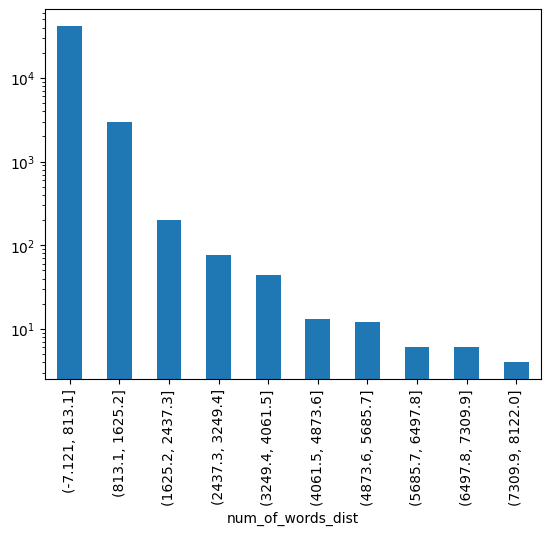

In [126]:
df['num_of_words_dist'].value_counts().plot(kind="bar")
plt.yscale("log")

# Detecção de outliers

In [127]:
df_without_text_vectors = df.drop(columns=['text_vector'])
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist
934,FINALLY! THE 538 ELECTORAL COLLEGE MEMBERS Cas...,WHAT YOU NEED TO KNOWIn all 50 state capitals ...,politics,"Dec 19, 2016",0,212.0,"[0.22657423, -0.02523838, 0.08157025, -0.02499...",0,0.0,0.025982,"(-7.121, 813.1]"
968,COINTEL PRO: Are ‘Anti-Fascist’ Media Personal...,21st Century Wire says In this age of hyperpol...,worldnews,"February 15, 2017",0,859.0,"[-0.113371015, -0.0934369564, -0.439139187, -0...",1,1.0,0.105652,"(813.1, 1625.2]"
1196,BLACK LIVES MATTER ORGANIZER Refuses To Meet W...,Pure gold The ultimate RaceBaiterInChief just ...,politics,"Feb 18, 2016",0,629.0,"[-0.19057435, 0.32218033, -0.40333083, 0.32286...",0,0.0,0.077330,"(-7.121, 813.1]"
1508,TOP DEMOCRAT ACTIVIST WHO LAUNCHED ONLINE CAMP...,CJ Pearson the 12 year old conservative social...,politics,"Jul 9, 2015",0,436.0,"[-0.2535226, -0.26469833, -0.45374283, -0.2489...",0,0.0,0.053565,"(-7.121, 813.1]"
1577,[Video] BLACK CHAMBER OF COMMERCE PRESIDENT SA...,America s First Black President continues to...,politics,"Jun 26, 2015",0,103.0,"[-0.25079003, 0.136780947, -0.0244115405, 0.30...",0,0.0,0.012560,"(-7.121, 813.1]"


In [128]:
duplicates_mask = df_without_text_vectors.duplicated(keep=False)

# Drop duplicates from the original DataFrame
df = df[~duplicates_mask]

In [129]:
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

C:\Users\guiL6\AppData\Local\Temp\ipykernel_5164\4099902805.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  duplicates = df[df_without_text_vectors.duplicated()]


,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist


<Axes: >

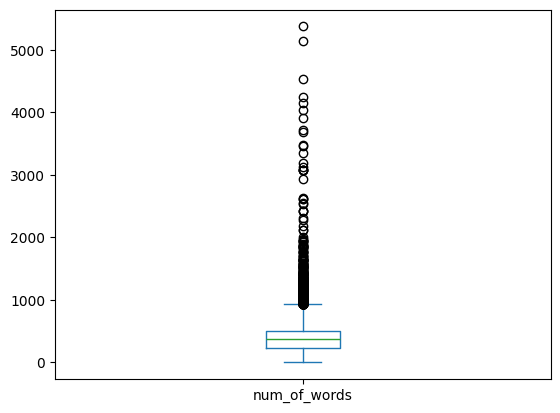

In [130]:
df['num_of_words'].plot.box()

<Axes: ylabel='Frequency'>

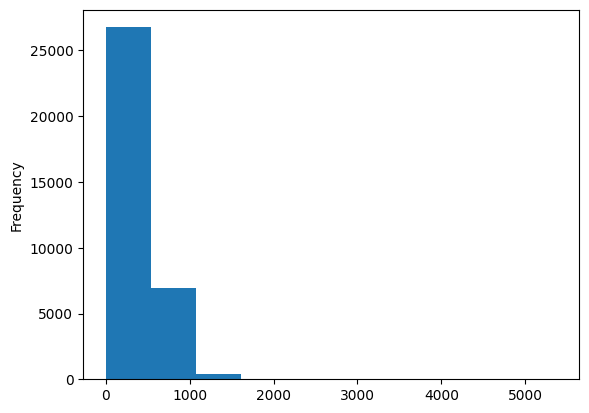

In [131]:
df['num_of_words'].plot.hist()

C:\Users\guiL6\AppData\Local\Temp\ipykernel_5164\1135887764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_num_of_words'] = np.log10(df['num_of_words'])


<Axes: ylabel='Frequency'>

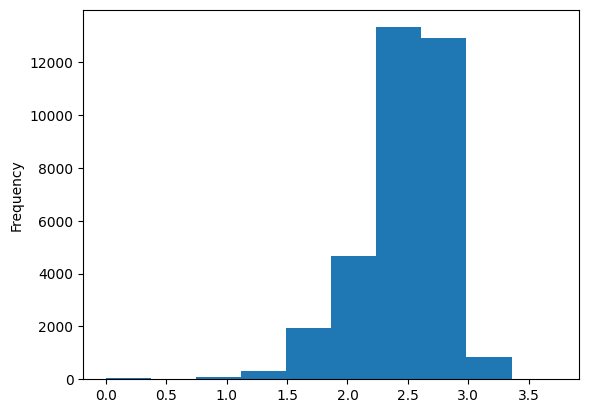

In [132]:
df['log_num_of_words'] = np.log10(df['num_of_words'])
df['log_num_of_words'].plot.hist()

In [133]:
mad = np.abs(df['log_num_of_words'] - df['log_num_of_words'].median()).median()*(1/0.6745)
print(mad)

0.23995673823731847


<Axes: >

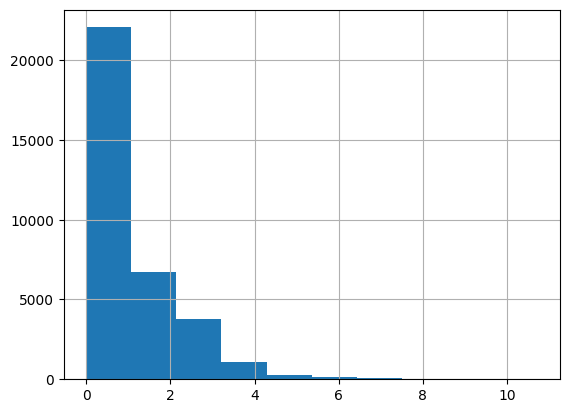

In [134]:
(np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad).hist()

In [135]:
df[np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad > 3.5]

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
141,SURPRISE! HISPANIC REPORTER Tries To Call Inju...,This video is just one of many examples showin...,politics,"Jun 11, 2016",0,31.0,"[-0.396636516, 0.0757741109, -0.439957738, 0.0...",0,0.0,0.003694,"(-7.121, 813.1]",1.491362
219,BENGHAZI HERO Slams Hillary In Pro Trump Ad Fu...,Mark Oz Geist makes a powerful ad against Hi...,politics,"Jun 29, 2016",0,28.0,"[-0.43475997, 0.44441986, -0.38001454, 0.21423...",0,0.0,0.003325,"(-7.121, 813.1]",1.447158
221,IRONIC: WHITE SOUTHERNER BILL CLINTON Just Tol...,OOPS IN 2008 BILL CLINTON SAID THE SAME THING ...,politics,"Sep 9, 2016",0,13.0,"[-0.174756706, 0.164166495, -0.0533468463, -0....",0,0.0,0.001478,"(-7.121, 813.1]",1.113943
227,MAN THREATENS TO KILL TRUMP: Afraid Food Stamp...,The Baton Rouge Louisiana resident Maine Musi...,politics,"May 20, 2016",0,45.0,"[0.246041238, 0.323674202, 0.298093081, 0.3309...",0,0.0,0.005418,"(-7.121, 813.1]",1.653213
306,Trump says will renegotiate NAFTA at 'appropri...,WASHINGTON Reuters President Donald Trump on ...,politics,"January 23, 2017",1,50.0,"[-0.27951512, -0.11165302, 0.20659702, 0.05565...",0,0.0,0.006034,"(-7.121, 813.1]",1.698970
...,...,...,...,...,...,...,...,...,...,...,...,...
44726,Text: Ex-FBI Director Comey's prepared testimo...,Reuters Following is the full text of former ...,politics,"June 7, 2017",1,3190.0,"[-0.32454476, -0.17206171, -0.16256896, 0.1117...",0,0.0,0.392686,"(2437.3, 3249.4]",3.503791
44792,AUDIENCE MEMBER GETS The Last Word When Michae...,Michael Moore Trump is a malignant narcissist...,politics,"Dec 7, 2016",0,20.0,"[0.148010686, -0.61836952, -0.102962993, -0.20...",0,0.0,0.002340,"(-7.121, 813.1]",1.301030
44803,Left Wing Hack George Stephanopoulos Picks A F...,This is fun George Stephanopoulos tries his be...,politics,"Dec 20, 2015",0,23.0,"[-0.0598408654, 0.263164401, 0.100914851, -0.2...",0,0.0,0.002709,"(-7.121, 813.1]",1.361728
44814,LISTEN UP! CHAIRMAN FOR TEENS FOR TRUMP Sends ...,CJ Pierson is such a great kid he s sending me...,politics,"Aug 13, 2016",0,30.0,"[-0.189118415, 0.18278794, -0.150763407, -0.22...",0,0.0,0.003571,"(-7.121, 813.1]",1.477121


In [136]:
len(df)

34147

In [137]:
df = df[abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad < 3.5]

In [138]:
len(df)

33073

# Gerando análises de similaridade

In [139]:
from scipy.stats import ttest_ind

# Convert the list of vectors to a numpy array
vectors = np.vstack(df['text_vector'].to_numpy())

# Build the FAISS index
dimension = vectors.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(vectors)

In [140]:
# Selecionando 1000 notícias falsas e 1000 verdadeiras para cada assunto
fake_data = df[df['label'] == 0].groupby('subject').sample(1000)
true_data = df[df['label'] == 1].groupby('subject').sample(1000)

# Concatenando os dados selecionados
selected_data = pd.concat([fake_data, true_data])

# Listas para armazenar as similaridades
fake_vs_fake_similarities = []
true_vs_true_similarities = []
true_vs_fake_similarities = []

for subject in ['politics', 'worldnews']:
    fake_indices = fake_data[fake_data['subject'] == subject].index
    true_indices = true_data[true_data['subject'] == subject].index
    
    for fake_index in fake_indices:
        query_vector = selected_data[selected_data.index == fake_index]['text_vector'].iloc[0]
        distances, indices = index.search(np.array([query_vector]), len(selected_data))
        
        # Encontrar similaridades falsas vs falsas
        fake_vs_fake_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in fake_indices])
        
        # Encontrar similaridades falsas vs verdadeiras
        true_indices_in_results = [i for i in indices[0] if i in true_indices]
        if true_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(true_indices_in_results[0])])
    
    for true_index in true_indices:
        query_vector = selected_data[selected_data.index == true_index]['text_vector'].iloc[0]
        distances, indices = index.search(np.array([query_vector]), len(selected_data))
        
        # Encontrar similaridades verdadeiras vs verdadeiras
        true_vs_true_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in true_indices])
        
        # Encontrar similaridades verdadeiras vs falsas
        fake_indices_in_results = [i for i in indices[0] if i in fake_indices]
        if fake_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(fake_indices_in_results[0])])

# Estatísticas descritivas

## Histograma de distribuição do número de palavras

O histograma ilustra a distribuição do número de palavras após uma transformação logarítmica. A maioria dos textos concentra-se em torno de cerca de 6 palavras, com uma diminuição gradual na frequência à medida que o número de palavras aumenta. Textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras) são menos comuns. Em suma, a análise revela que a maioria dos textos possui um número moderado de palavras, com uma concentração significativa em torno de 6 palavras, destacando a predominância de textos de comprimento médio.

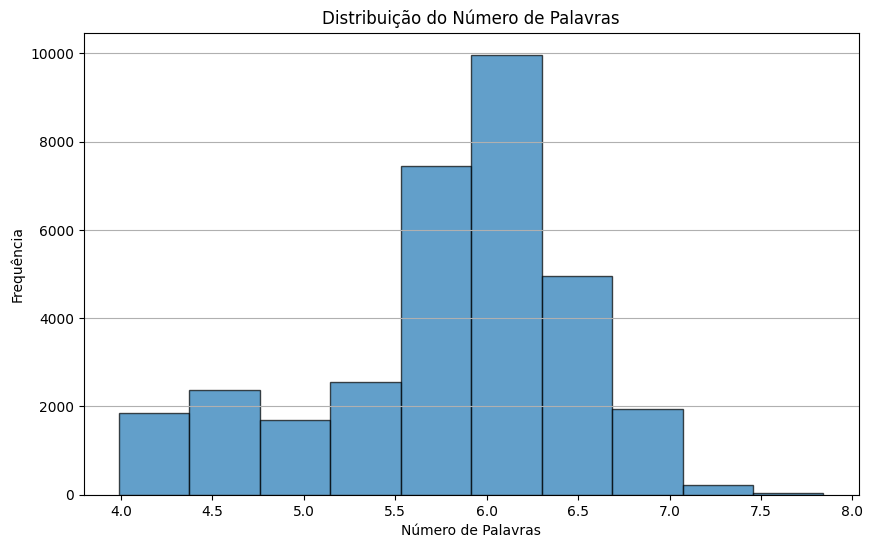

In [141]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(df['num_of_words']), bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

## Boxplot representando o número de palavras

O boxplot mostra a distribuição do número de palavras em textos após uma transformação logarítmica. A mediana é cerca de 6, sugerindo que a maioria dos textos tem em torno de 6 palavras. A caixa do boxplot, entre o primeiro e terceiro quartil, indica que 50% dos textos possuem entre aproximadamente 5 e 6,5 palavras. Os "whiskers" indicam a variação esperada dos dados até 1,5 vezes o intervalo interquartil (IQR). Além disso, há outliers representando textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras). Em síntese, a análise revela que a maioria dos textos tem um número moderado de palavras, com a predominância de textos de comprimento médio, sendo textos extremamente curtos ou longos menos frequentes.

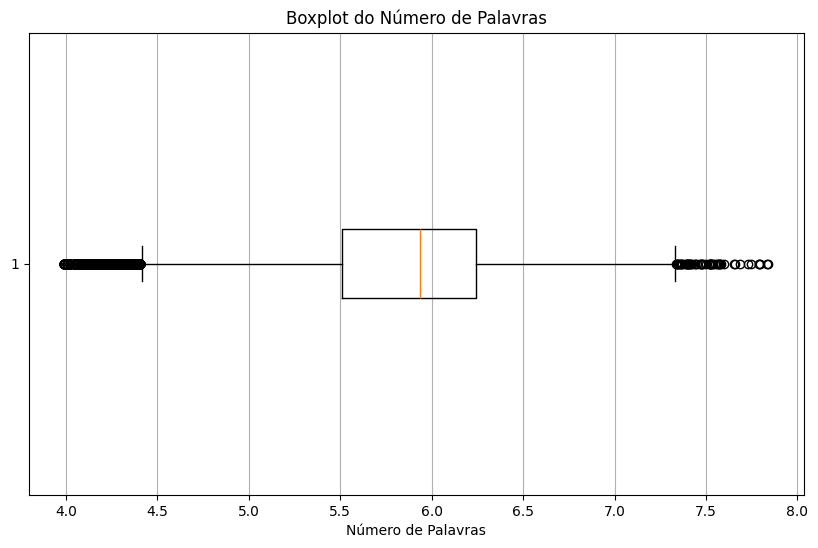

In [142]:
# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(np.log(df['num_of_words']), vert=False)
plt.title('Boxplot do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.grid(axis='x')
plt.show()

## Gráfico de barras comparando o número de notícias falsas vs verdadeiras por ano

O gráfico abaixo compara o número de notícias falsas e verdadeiras publicadas anualmente de 2015 a 2018. 
As conclusões são:

2015: Poucas notícias, com ligeira predominância das falsas.
2016: Aumento significativo de notícias, com mais falsas do que verdadeiras.
2017: Pico de notícias, com um aumento expressivo em ambas as categorias, sendo as verdadeiras consideravelmente mais numerosas.
2018: Poucas notícias, tanto falsas quanto verdadeiras, indicando baixa coleta de dados ou atividade mínima.

Em resumo, o período de 2016 a 2017 registrou um aumento acentuado na produção ou coleta de notícias, com destaque para 2017, especialmente para as notícias verdadeiras.

In [143]:
date_formats = ['%B%d,%Y', '%d-%b-%y', '%B%d,%Y', '%b%d,%Y', '%d-%b-%Y', '%d%B%Y', '%d%b%Y', '%Y-%m-%d', '%m-%d-%Y', '%Y/%m/%d', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y']

def is_valid_date(date_str):
    for format_str in date_formats:
        try:
            return pd.to_datetime(re.sub(r'\s+', '', str(date_str)), format=format_str)
        except ValueError:
            pass

    return pd.NaT

valid_dates = df.copy()
valid_dates['date'] = valid_dates['date'].map(is_valid_date)
valid_dates['year'] = valid_dates['date'].dt.year

<Figure size 1200x600 with 0 Axes>

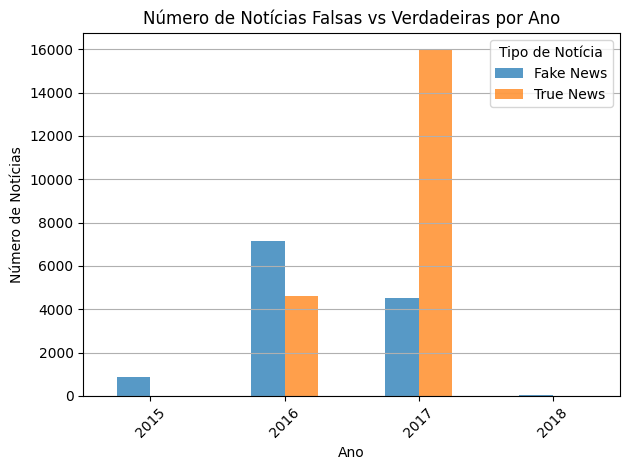

In [144]:
# Contar o número de notícias falsas e verdadeiras por ano
fake_news_per_year = valid_dates[valid_dates['label'] == 0].groupby('year').size()
true_news_per_year = valid_dates[valid_dates['label'] == 1].groupby('year').size()

# Criar um DataFrame com esses dados
news_counts_per_year = pd.DataFrame({
    'Fake News': fake_news_per_year,
    'True News': true_news_per_year
}).fillna(0)  # Preencher valores ausentes com 0

# Plotar o gráfico
plt.figure(figsize=(12, 6))
news_counts_per_year.plot(kind='bar', stacked=False, alpha=0.75)
plt.title('Número de Notícias Falsas vs Verdadeiras por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Notícias')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Notícia')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## Gráfico de Similaridade em Notícias Verdadeiras, Falsas e Mistas

### Descrição dos Gráficos de Similaridade em Notícias Verdadeiras, Falsas e Mistas

O gráfico compara a similaridade das notícias falsas, verdadeiras e mistas em relação aos subjects "worldnews" e "politics". A similaridade é representada pela distância média (quanto menor a distância, maior a similaridade).

### Análise

- Fake vs Fake: Notícias falsas têm uma similaridade moderada, com uma distância média em torno de 20.
- True vs True: Notícias verdadeiras têm a menor similaridade, com a maior distância média, ligeiramente acima de 20.
- True vs Fake: Notícias mistas têm a maior similaridade, com a menor distância média, aproximadamente 15.

### Conclusão

As notícias mistas (verdadeiras vs falsas) mostram maior similaridade entre si, indicando que as notícias verdadeiras e falsas compartilham características comuns. As notícias verdadeiras mantêm menor similaridade quando comparadas entre si, enquanto as notícias falsas também têm uma similaridade moderada dentro do seu grupo.

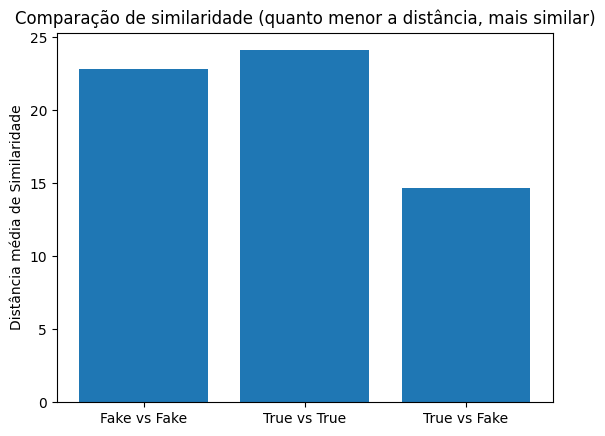

In [145]:
# Calculando as médias das similaridades
labels = ['Fake vs Fake', 'True vs True', 'True vs Fake']
similarities = [np.mean(fake_vs_fake_similarities), np.mean(true_vs_true_similarities), np.mean(true_vs_fake_similarities)]

# Plotando as similaridades
plt.bar(labels, similarities)
plt.ylabel('Distância média de Similaridade')
plt.title('Comparação de similaridade (quanto menor a distância, mais similar)')
plt.show()

# Teste de hipótese

## Teste de Hipótese: Similaridade entre Notícias Verdadeiras, Falsas e Mistas

Neste notebook, realizaremos um teste de hipótese para comparar a similaridade entre notícias verdadeiras, falsas e mistas. A similaridade é medida pela distância média (quanto menor a distância, maior a similaridade). O objetivo é determinar se há uma diferença significativa na similaridade entre as diferentes categorias de notícias.

### Passos do Teste de Hipótese

#### Definir Hipóteses:

- \(H_0\) (Hipótese Nula): Não há diferença significativa na similaridade entre as diferentes categorias de notícias.
- \(H_a\) (Hipótese Alternativa): Há uma diferença significativa na similaridade entre as diferentes categorias de notícias.

#### Calcular as Distâncias Médias:

- Obter as distâncias médias para cada categoria: Fake vs Fake, True vs True, e True vs Fake.

#### Realizar Teste de Hipótese:

- Usar o teste t de Student para comparar as distâncias médias entre as categorias.

#### Analisar os Resultados:

- Interpretar os valores p para determinar se rejeitamos ou não a hipótese nula.

## Resultados dos Testes de Hipótese

Os resultados dos testes para comparar as similaridades entre as diferentes categorias de notícias são os seguintes:

### Teste entre Fake vs Fake e True vs True:

- T-statistic: -16.37274849962382
- P-value: 1.6354346712162612e-56
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs True.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre Fake vs Fake e True vs Fake:

- T-statistic: 25.650055569958536
- P-value: 1.199788220568109e-125
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs Fake.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre True vs True e True vs Fake:

- T-statistic: 44.84103110401803
- P-value: 2.239345677091325e-302
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre True vs True e True vs Fake.
- Observação: O resultado é altamente significativo (p < 0.01).


In [146]:
def perform_t_test(sample1, sample2, label1, label2):
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)
    print(f"Teste t de Student entre {label1} e {label2}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}\n")
    
    # Interpretação dos resultados
    alpha = 0.05  # Nível de significância de 5%
    if p_value < alpha:
        print(f"Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre {label1} e {label2}.")
    else:
        print(f"Resultado: Não rejeitamos a hipótese nula. Não há diferença significativa na similaridade entre {label1} e {label2}.")

    # Detalhes adicionais para interpretação
    if p_value < 0.01:
        print("Observação: O resultado é altamente significativo (p < 0.01).")
    elif p_value < 0.05:
        print("Observação: O resultado é estatisticamente significativo (p < 0.05).")
    else:
        print("Observação: O resultado não é estatisticamente significativo (p >= 0.05).")

    print("\n" + "-"*50 + "\n")

# Realizando os testes de hipótese
cropped_sample_fake_vs_fake = random.sample(fake_vs_fake_similarities, 1000)
cropped_sample_true_vs_true = random.sample(true_vs_true_similarities, 1000)
cropped_sample_true_vs_fake = random.sample(true_vs_fake_similarities, 1000)

perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_true, 'Fake vs Fake', 'True vs True')
perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_fake, 'Fake vs Fake', 'True vs Fake')
perform_t_test(cropped_sample_true_vs_true, cropped_sample_true_vs_fake, 'True vs True', 'True vs Fake')

Teste t de Student entre Fake vs Fake e True vs True:
T-statistic: -2.8677409307744113
P-value: 0.004195058568284152

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs True.
Observação: O resultado é altamente significativo (p < 0.01).

--------------------------------------------------

Teste t de Student entre Fake vs Fake e True vs Fake:
T-statistic: 26.11694088298905
P-value: 2.1212533265081808e-125

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs Fake.
Observação: O resultado é altamente significativo (p < 0.01).

--------------------------------------------------

Teste t de Student entre True vs True e True vs Fake:
T-statistic: 44.847550640554516
P-value: 1.6122580352857345e-301

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre True vs True e True vs Fake.
Observação: O resultado é altamente significativo 

## Teste Qui-Quadrado para Proporção de Notícias Falsas em Textos Curtos e Longos

O código abaixo realiza um teste qui-quadrado de contingência para avaliar a proporção de notícias falsas em textos curtos (com menos de 150 palavras) e longos (com 150 palavras ou mais). Após dividir as notícias em categorias com base no comprimento, são calculadas as proporções de notícias falsas e verdadeiras em cada categoria. O teste estatístico é realizado e o resultado é exibido, mostrando a estatística Qui-Quadrado (Chi2) e o valor P associado. No caso específico deste teste, em que o resultado foi: Chi2 statistic: 2153.80, P-value: 0.00000, conclui-se que há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto. As proporções de notícias falsas e verdadeiras são exibidas para ambas as categorias, e é destacado que é mais provável que um texto longo seja uma notícia falsa em comparação a um texto curto, enquanto é mais provável que um texto curto seja uma notícia verdadeira em comparação a um texto longo.

In [147]:
from scipy.stats import chi2_contingency

# Dividir as notícias em curtas e longas
short_texts = new_df[new_df['num_of_words'] < 150]
long_texts = new_df[new_df['num_of_words'] >= 150]

# Calcular a proporção de notícias falsas e verdadeiras em cada categoria
short_fake_count = short_texts[short_texts['label'] == 0].shape[0]
short_true_count = short_texts[short_texts['label'] == 1].shape[0]
long_fake_count = long_texts[long_texts['label'] == 0].shape[0]
long_true_count = long_texts[long_texts['label'] == 1].shape[0]

short_fake_proportion = short_fake_count / short_texts.shape[0]
short_true_proportion = short_true_count / short_texts.shape[0]
long_fake_proportion = long_fake_count / long_texts.shape[0]
long_true_proportion = long_true_count / long_texts.shape[0]

# Preparar os dados para o teste qui-quadrado de contingência
contingency_table = pd.DataFrame({
    'Short Texts': [short_fake_count, short_true_count],
    'Long Texts': [long_fake_count, long_true_count]
}, index=['Fake', 'True'])

# Realizar o teste qui-quadrado de contingência
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 statistic: {chi2:.2f}, P-value: {p:.5f}")

if p < 0.05:
    print("Há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto.")

    print(f"Proporção de notícias falsas entre textos curtos: {short_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos curtos: {short_true_proportion:.2%}")
    print(f"Proporção de notícias falsas entre textos longos: {long_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos longos: {long_true_proportion:.2%}")

    if short_fake_proportion > long_fake_proportion:
        print("É mais provável que um texto curto seja uma notícia falsa comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia falsa comparado a um texto curto.")

    if short_true_proportion > long_true_proportion:
        print("É mais provável que um texto curto seja uma notícia verdadeira comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia verdadeira comparado a um texto curto.")
else:
    print("Não há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa não está associada ao comprimento do texto.")

NameError: name 'new_df' is not defined

# Classificação

In [152]:
# setando label para int, para utilizar o modelo
df['label'] = df['label'].astype('int')
df.dtypes

title                  object
text                   object
subject                object
date                   object
label                   int32
num_of_words          float64
text_vector            object
num_subjects           object
subject_norm          float64
num_of_words_norm     float64
num_of_words_dist    category
log_num_of_words      float64
dtype: object

In [153]:
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
0,"Trump administration switches sides, backs Ohi...",Reuters The Trump administration has reversed...,politics,"August 8, 2017",1,471.0,"[-0.140370145, -0.105049334, -0.14454563, -0.0...",0,0.0,0.057875,"(-7.121, 813.1]",2.673021
1,Mansion where Obama to stay in Havana 'built t...,HAVANA Reuters The mansion in Havana where US...,politics,"March 18, 2016",1,406.0,"[-0.09919216, 0.22871518, 0.09011927, 0.259386...",0,0.0,0.049871,"(-7.121, 813.1]",2.608526
2,Mexican army hit by execution finding as Senat...,MEXICO CITY Reuters Mexican soldiers arbitrar...,worldnews,"December 6, 2017",1,674.0,"[-0.02632321, 0.31772003, -0.08805364, -0.0658...",1,1.0,0.082872,"(-7.121, 813.1]",2.828660
3,Republican Senate candidate Moore hit by sexua...,Reuters A woman has accused Roy Moore the Rep...,politics,"November 9, 2017",1,907.0,"[0.0551192, -0.23961988, -0.18442997, -0.05860...",0,0.0,0.111563,"(813.1, 1625.2]",2.957607
4,(VIDEO) Elitist Media Stoops To New Low Attack...,The elitist media is exposing its bias and dis...,politics,"Sep 24, 2015",0,128.0,"[0.2871213, -0.25076506, -0.4020861, -0.167454...",0,0.0,0.015638,"(-7.121, 813.1]",2.107210


In [166]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_df = df[['num_of_words_norm','subject_norm']]
y_df = df['label']
xtrain, xtest, ytrain, ytest = train_test_split(x_df, y_df, random_state=1)

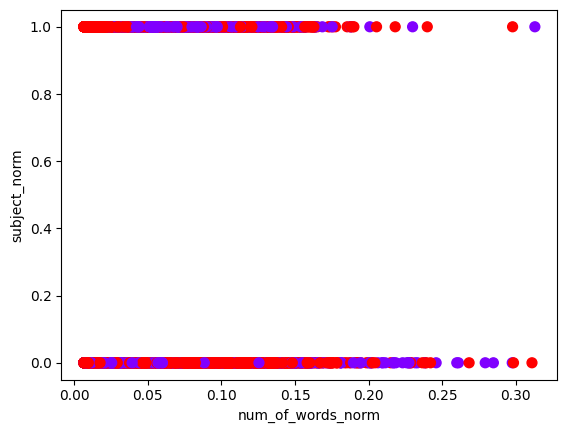

In [180]:
plt.scatter(x_df.iloc[:, 0], x_df.iloc[:, 1], c=y_df, s=50, cmap='rainbow')
plt.xlabel('num_of_words_norm')
plt.ylabel('subject_norm')
plt.show()

### Algoritmo 1

In [168]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=1)
rf.fit(xtrain, ytrain)
y_pred_rf = rf.predict(xtest)      

In [169]:
accuracy_score(ytest, y_pred_rf)

0.7300761881726932

Text(113.9222222222222, 0.5, 'predicted label')

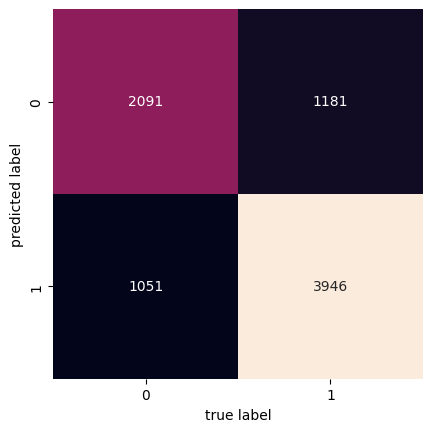

In [170]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, y_pred_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Algoritmo 2

In [171]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(xtrain, ytrain)

y_model = model.predict(xtest)

In [172]:
accuracy_score(ytest, y_model)

0.6940379731527392

Text(113.9222222222222, 0.5, 'predicted label')

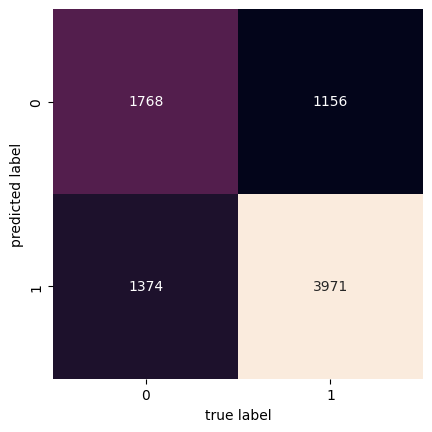

In [173]:
mat = confusion_matrix(ytest, y_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Algoritmo 3

In [174]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(xtrain, ytrain)
y_pred_svm = svm.predict(xtest)

In [175]:
accuracy_score(ytest, y_pred_svm)


0.6856935542387229

Text(113.9222222222222, 0.5, 'predicted label')

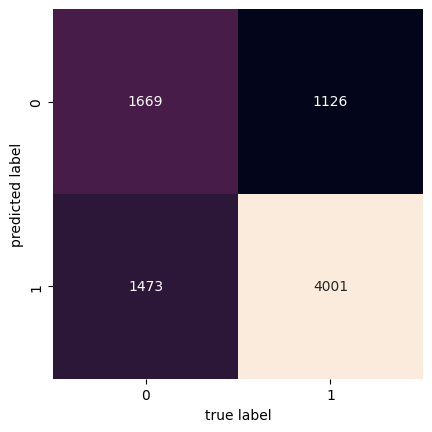

In [176]:
mat = confusion_matrix(ytest, y_pred_svm)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Algoritmo 4

In [177]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(xtrain, ytrain)
y_pred_log_reg = log_reg.predict(xtest)


In [178]:
accuracy_score(ytest, y_pred_log_reg)

0.6241383480469223

Text(113.9222222222222, 0.5, 'predicted label')

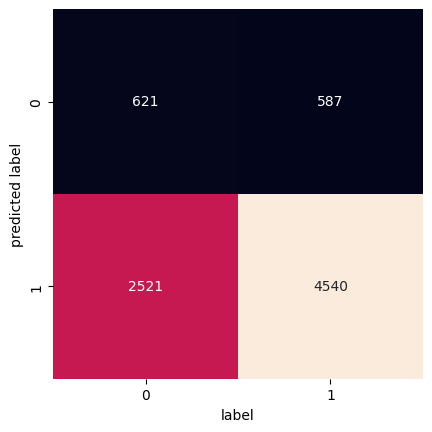

In [181]:
mat = confusion_matrix(ytest, y_pred_log_reg)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('label')
plt.ylabel('predicted label')